In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

In [2]:
# Load the Excel file
data = pd.read_excel('data/datafile01.xlsx')

# Display the first few rows
print(data.head())

        Time       Price    Call_80    Put_80    Call_90    Put_90   Call_100  \
0 2023-01-01  100.000000  37.787444  3.285904  31.882222  5.567990  26.703538   
1 2023-01-02  100.045144  37.827128  3.280444  31.919140  5.559764  26.737350   
2 2023-01-03  100.385755  38.126839  3.239544  32.198070  5.498083  26.992932   
3 2023-01-04   99.899132  37.698809  3.298137  31.799779  5.586414  26.628041   
4 2023-01-05   99.654190  37.483763  3.328033  31.599829  5.631406  26.445011   

    Put_100   Call_110    Put_110   Call_120    Put_120   Call_ATM   Put_ATM  
0  8.576613  22.234651  12.295034  18.428278  16.675968  26.703538  8.576613  
1  8.565282  22.265196  12.280434  18.455543  16.658090  26.715593  8.580485  
2  8.480252  22.496178  12.170806  18.661828  16.523763  26.806548  8.609698  
3  8.601984  22.166463  12.327714  18.367420  16.715978  26.676602  8.567962  
4  8.663896  22.001221  12.407414  18.220002  16.813502  26.611194  8.546954  


In [3]:
# print(data.isnull().sum())
# data = data.dropna()  # Or use data.fillna(method='ffill')
# print(data.dtypes)
# Convert data types if necessary

pct_change_periods = [1, 5, 21] # Typical month has 21 trading days
for pct in pct_change_periods:
    data[f'{pct}-day_Return'] = data['Price'].pct_change(periods=pct)

In [4]:
data = data.dropna()
print(data.head())

         Time      Price    Call_80    Put_80    Call_90    Put_90   Call_100  \
21 2023-01-22  89.090140  28.504439  4.912759  23.355155  7.950783  18.997768   
22 2023-01-23  87.549760  27.250885  5.199585  22.222668  8.358675  17.992124   
23 2023-01-24  86.870469  26.703280  5.331271  21.729585  8.544884  17.555767   
24 2023-01-25  87.245673  27.005346  5.258133  22.001450  8.441545  17.796242   
25 2023-01-26  85.577947  25.670467  5.590981  20.802416  8.910237  16.737822   

      Put_100   Call_110    Put_110   Call_120    Put_120   Call_ATM  \
21  11.780703  15.368603  16.338847  12.382849  21.540400  23.790219   
22  12.315439  14.488435  16.999058  11.621643  22.319573  23.378883   
23  12.558373  14.107840  17.297754  11.293613  22.670834  23.197488   
24  12.423644  14.317484  17.132194  11.474216  22.476233  23.297681   
25  13.032950  13.396654  17.879090  10.682547  23.352291  22.852339   

     Put_ATM  1-day_Return  5-day_Return  21-day_Return  
21  7.640916     -0.00

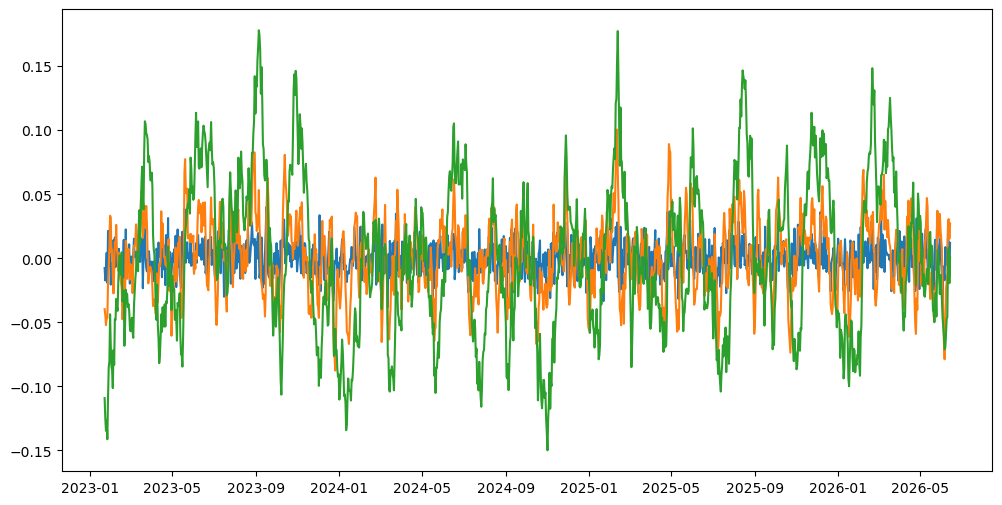

In [5]:
plt.figure(figsize=(12,6))
plt.plot(data['Time'], data['1-day_Return'])
plt.plot(data['Time'], data['5-day_Return'])
plt.plot(data['Time'], data['21-day_Return'])
plt.show()

In [6]:
# Extract option column names
option_columns = [col for col in data.columns if ('Call_' in col or 'Put_' in col)]

strike_prices = []
atm_options = []

for col in option_columns:
    parts = col.split('_')
    if len(parts) == 2:
        strike = parts[1]
        if strike.isdigit():
            # Add numeric strike prices to the list
            strike_prices.append(int(strike))
        elif strike == 'ATM':
            # Handle ATM options separately
            atm_options.append(col)
        else:
            print(f"Skipping column {col} as strike price is not a digit or 'ATM'")
    else:
        print(f"Skipping column {col} as it does not have the expected format.")

# Remove duplicate strike prices and sort them
strike_prices = sorted(set(strike_prices))

print(f"Available Strike Prices: {strike_prices}")
print(f"ATM Options: {atm_options}")

Available Strike Prices: [80, 90, 100, 110, 120]
ATM Options: ['Call_ATM', 'Put_ATM']


In [7]:
def black_scholes(S, K, T, r, sigma, option_type='call'):
    
    T = max(T, 1e-10)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    try:
        if option_type == 'call':
            price = S * norm.cdf(d1) - norm.cdf(d2) * K * np.exp(- r * T)
        elif option_type == 'put':
            price = K * np.exp(- r * T) * norm.cdf(- d2) - S * norm.cdf(- d1)
        else:
            raise ValueError("option_price must be a 'call' or a 'put'")
        return price
    except Exception as e:
        print(f"Error calculating option price: {e}")
        return np.nan  # Return NaN to handle exceptions

In [8]:
def calculate_option_delta(S, K, T, r, sigma, option_type='call'):
    """
    Calculate the delta of an option using the Black-Scholes formula.
    """
    if T <= 0 or sigma <= 0:
        # Option expires today or zero volatility
        if option_type == 'call':
            delta = 1.0 if S > K else 0.0
        else:
            delta = 0.0 if S >= K else -1.0
    else:
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        if option_type == 'call':
            delta = norm.cdf(d1)
        elif option_type == 'put':
            delta = norm.cdf(d1) - 1
        else:
            raise ValueError("option_type must be 'call' or 'put'")
    return delta

In [9]:
# Assume risk-free rate and compute volatility
r = 0.01  # Example risk-free rate
data['Volatility'] = data['1-day_Return'].rolling(window=21).std() * np.sqrt(252)
data['Volatility'].fillna(method='bfill', inplace=True)
# Add a small value to sigma to avoid zero volatility
data['Volatility'] = data['Volatility'].apply(lambda x: max(x, 1e-8))

# Time to expiry (assuming 1 year as per your data)
data['Time_to_Expiry'] = 1.0  # In years

/var/folders/j0/tqzlnmks6cx221q8pl95104w0000gn/T/ipykernel_89984/2886475184.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Volatility'].fillna(method='bfill', inplace=True)
/var/folders/j0/tqzlnmks6cx221q8pl95104w0000gn/T/ipykernel_89984/2886475184.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Volatility'].fillna(method='bfill', inplace=True)


In [10]:
# Calculate delta for ATM options
for option_col in atm_options:
    option_type, _ = option_col.split('_')
    delta_col = f"Delta_{option_col}"
    data[delta_col] = data.apply(
        lambda row: calculate_option_delta(
            S=row['Price'],
            K=row['Price'],  # Strike price equals stock price for ATM options
            T=row['Time_to_Expiry'],
            r=r,
            sigma=row['Volatility'],
            option_type=option_type.lower()
        ),
        axis=1
    )

# Calculate delta for options with numeric strike prices
for K in strike_prices:
    for option_type in ['Call', 'Put']:
        option_col = f"{option_type}_{K}"
        delta_col = f"Delta_{option_type}_{K}"
        if option_col in data.columns:
            data[delta_col] = data.apply(
                lambda row: calculate_option_delta(
                    S=row['Price'],
                    K=K,
                    T=row['Time_to_Expiry'],
                    r=r,
                    sigma=row['Volatility'],
                    option_type=option_type.lower()
                ),
                axis=1
            )
        else:
            print(f"Option column {option_col} not found in the data.")

In [11]:
def calculate_option_price(S, K, T, r, sigma, option_type='call'):
    """
    Calculate the price of an option using the Black-Scholes formula.
    """
    if T <= 0 or sigma <= 0:
        # Option expires today or zero volatility
        if option_type == 'call':
            return max(S - K, 0)
        else:
            return max(K - S, 0)
    else:
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if option_type == 'call':
            price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        elif option_type == 'put':
            price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        else:
            raise ValueError("option_type must be 'call' or 'put'")
        return price

In [12]:
def delta_hedging_over_time(data, initial_capital=100000, option_col='Call_ATM'):
    """
    Perform delta hedging over the option's lifespan using the specified option.
    
    Parameters:
    - data: DataFrame containing the market data.
    - initial_capital: Starting capital for the strategy.
    - option_col: The option column to use for hedging (e.g., 'Call_ATM').
    
    Returns:
    - portfolio_values: List of portfolio values over time.
    """
    cash = initial_capital
    stock_position = 0
    option_position = 1  # Start with one option contract
    portfolio_values = []
    positions = []  # To track position over time
    T = 1.0  # Initial time to expiry in years

    # Ensure the delta column exists
    delta_col = f'Delta_{option_col}'
    if delta_col not in data.columns:
        print(f"Delta column {delta_col} not found in the data.")
        return []
    
    # Set risk-free rate
    r = 0.01  # Example risk-free rate
    
    # Time decrement per day
    dt = 1 / 252  # Assuming 252 trading days per year
    
    for index, row in data.iterrows():
        S = row['Price']
        sigma = row['Volatility']
        
        # Update time to expiry
        if T > 0:
            T -= dt
        else:
            T = 0
        
        # Recalculate option price and delta using Black-Scholes formula
        K = S if 'ATM' in option_col else int(option_col.split('_')[1])
        option_type = 'call' if 'Call' in option_col else 'put'
        option_price = calculate_option_price(
            S, K, T, r, sigma, option_type=option_type
        ) * 100  # Option price per contract
        delta = calculate_option_delta(
            S, K, T, r, sigma, option_type=option_type
        )
        
        # Number of shares to hedge (delta hedging)
        desired_stock_position = delta * 100 * option_position
        
        # Adjust stock position
        stock_trade = desired_stock_position - stock_position
        cash -= stock_trade * S
        stock_position += stock_trade
        
        # Update portfolio value
        portfolio_value = cash + stock_position * S + option_price * option_position
        portfolio_values.append(portfolio_value)
        
        # Track positions
        positions.append({
            'Day': index,
            'Stock_Position': stock_position,
            'Option_Position': option_position,
            'Option_Price': option_price,
            'Delta': delta,
            'Portfolio_Value': portfolio_value
        })
        
        # If option expires, reset positions
        if T == 0:
            # Settle option payoff
            if option_type == 'call':
                option_payoff = max(S - K, 0) * 100 * option_position
            else:
                option_payoff = max(K - S, 0) * 100 * option_position
            cash += option_payoff
            option_position = 0
            T = 1.0  # Reset time to expiry for next option
            option_position = 1  # Assume we purchase a new option
            stock_position = 0  # Reset stock position
            cash -= option_price * option_position  # Purchase new option
            continue  # Skip to next iteration

    return portfolio_values, positions

In [13]:
# Run the updated delta hedging strategy
delta_portfolio_values, positions = delta_hedging_over_time(
    data, initial_capital=100000, option_col='Call_ATM'
)

# Calculate total return
if delta_portfolio_values:
    delta_total_return = delta_portfolio_values[-1] - 100000
    print(f"Total Return from Delta Hedging Over Time: {delta_total_return:.2f}")
else:
    print("Delta hedging strategy did not return any portfolio values.")

Total Return from Delta Hedging Over Time: 144.27


In [14]:
# Run the updated delta hedging strategy
delta_portfolio_values, positions = delta_hedging_over_time(
    data, initial_capital=100000, option_col='Call_ATM'
)